In [12]:
import torch
# run pip install denoising_diffusion_pytorch first
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Trainer1D, Dataset1D
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


In [13]:
data_dim = 64
all_embeds = np.load('/home/local/ASUAD/ywan1053/gcn/MERIT-main/embed/cora/all_embs.npy')
gt_labels = np.load('/home/local/ASUAD/ywan1053/gcn/MERIT-main/embed/cora/all_gt_labels.npy')
pca = PCA(n_components=data_dim)
all_embeds = pca.fit_transform(all_embeds)
print(all_embeds.shape)
print(gt_labels.shape)

(2708, 64)
(2708,)


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.001s...
[t-SNE] Computed neighbors for 2708 samples in 0.139s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 0.048289
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.927284
[t-SNE] KL divergence after 1000 iterations: 0.758363


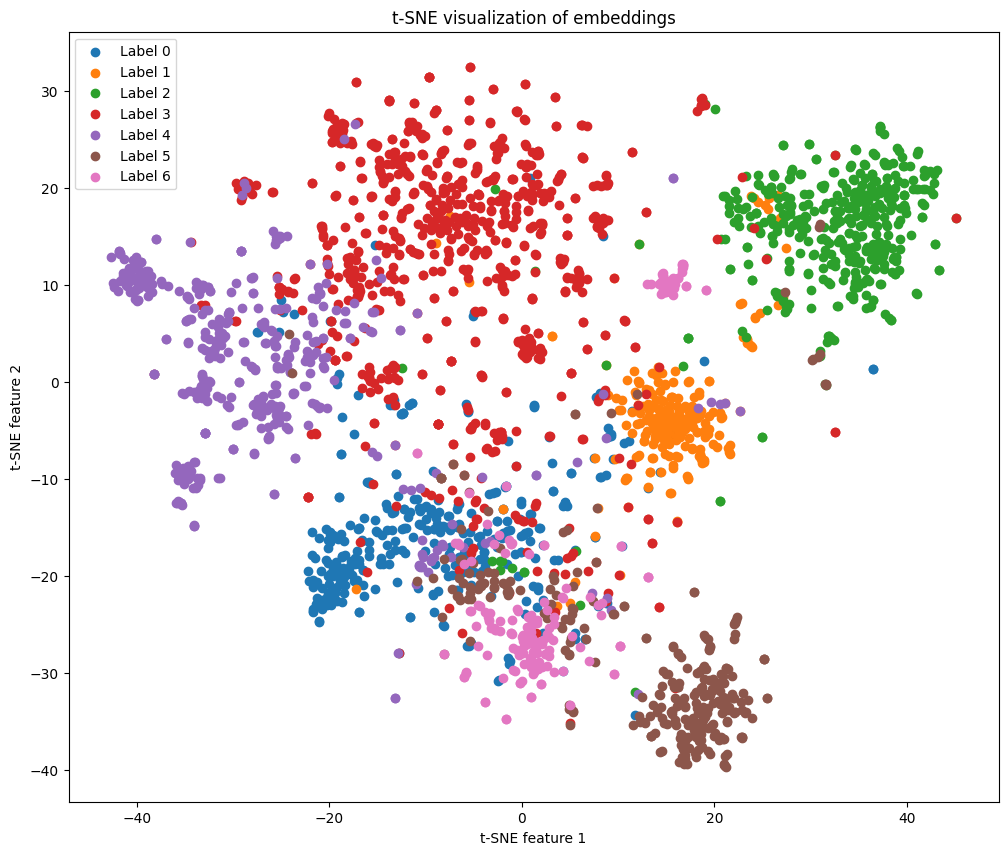

In [14]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(all_embeds)
# Plotting
plt.figure(figsize=(12, 10))

# Scatter plot of the reduced data, color by label
for i in range(len(np.unique(gt_labels))):  # Assuming your labels are 0-indexed categories
    plt.scatter(tsne_results[gt_labels == i, 0], tsne_results[gt_labels == i, 1], label=f'Label {i}')

plt.legend()
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of embeddings')
plt.show()

In [15]:
scaler = MinMaxScaler()
normalized_all_embeds = scaler.fit_transform(all_embeds)
training_seq = torch.FloatTensor(normalized_all_embeds[:,None,:])
print(training_seq.shape)
dataset = Dataset1D(training_seq) 

torch.Size([2708, 1, 64])


In [16]:
model = Unet1D(
    dim = 16,
    dim_mults = (1, 2, 4, 8),
    channels = 1
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = data_dim,
    timesteps = 1000,
    objective = 'pred_v'
)

In [17]:
trainer = Trainer1D(
    diffusion,
    dataset = dataset,
    train_batch_size = 64,
    train_lr = 8e-5,
    train_num_steps = 1000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
)

In [18]:
trainer.train()

loss: 0.1230: 100%|██████████| 1000/1000 [04:04<00:00,  4.09it/s]

training complete


In [19]:
sampled_seq = diffusion.sample(batch_size = 512)
print(sampled_seq.shape)

sampling loop time step: 100%|██████████| 1000/1000 [00:17<00:00, 58.37it/s]

torch.Size([512, 1, 64])


In [20]:
generated_embeds = sampled_seq.detach().cpu().numpy()[:,0,:]
generated_embeds = scaler.inverse_transform(generated_embeds)
print(generated_embeds.shape)
generated_lables = np.zeros(generated_embeds.shape[0]) - 1
print(generated_lables.shape)

combined_embeds = np.concatenate((all_embeds, generated_embeds), axis=0)
print(combined_embeds.shape)
combined_labels = np.concatenate((gt_labels, generated_lables), axis=0)
print(combined_labels.shape)

(512, 64)
(512,)
(3220, 64)
(3220,)


In [21]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(combined_embeds)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 3220 samples in 0.001s...
[t-SNE] Computed neighbors for 3220 samples in 0.244s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3220
[t-SNE] Computed conditional probabilities for sample 2000 / 3220
[t-SNE] Computed conditional probabilities for sample 3000 / 3220
[t-SNE] Computed conditional probabilities for sample 3220 / 3220
[t-SNE] Mean sigma: 0.044579
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.268333
[t-SNE] KL divergence after 1000 iterations: 1.021083


(2708, 2)
(512, 2)


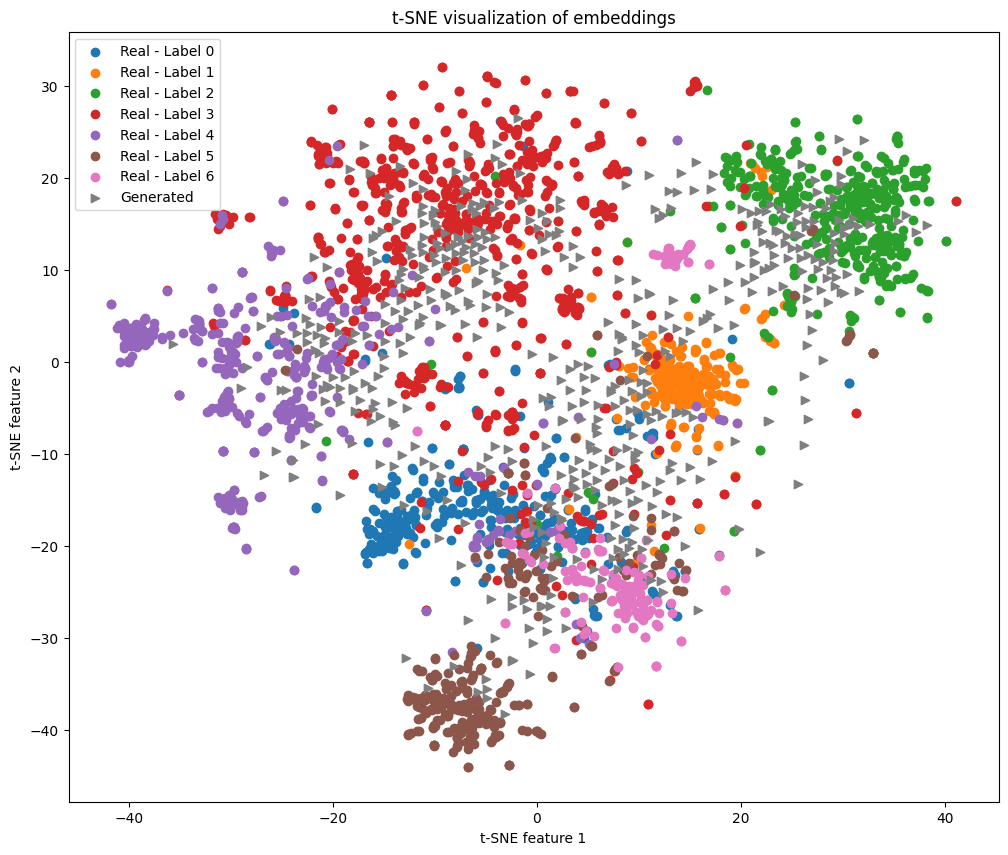

In [22]:
# Plotting
plt.figure(figsize=(12, 10))

n_real = all_embeds.shape[0]

tsne_results_real = tsne_results[:n_real]
print(tsne_results_real.shape)
tsne_results_generated = tsne_results[n_real:]
print(tsne_results_generated.shape)

unique_labels = np.unique(gt_labels)  # Get all unique labels from both sets

for i in unique_labels:  # Iterate through each unique label
    # Plot real data
    plt.scatter(tsne_results_real[gt_labels == i, 0], tsne_results_real[gt_labels == i, 1],  label=f'Real - Label {i}')
    
# Plot generated data
plt.scatter(tsne_results_generated[:, 0], tsne_results_generated[:, 1], label=f'Generated', marker='>')

plt.legend()
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of embeddings')
plt.show()